In [1]:
from tyxe_runfiles import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine

import dill

In [2]:
BASE_DIR = "./tests/sanity_check_mcmc"
PROFILE = "tyxe-test"

#BASE_DIR = "./tests/x-dim-test"
#PROFILE = "test"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-1k ======
Train: (-10, 10)
Y-space: -2.445995590283073 - 2.2643438832509464
In Domain: (-10, 10)
Y-space: -2.292038921098926 - 2.1208595881462915
Out Domain: (-20, 20)
Y-space: -2.2153775188109868 - 2.4024802423086653


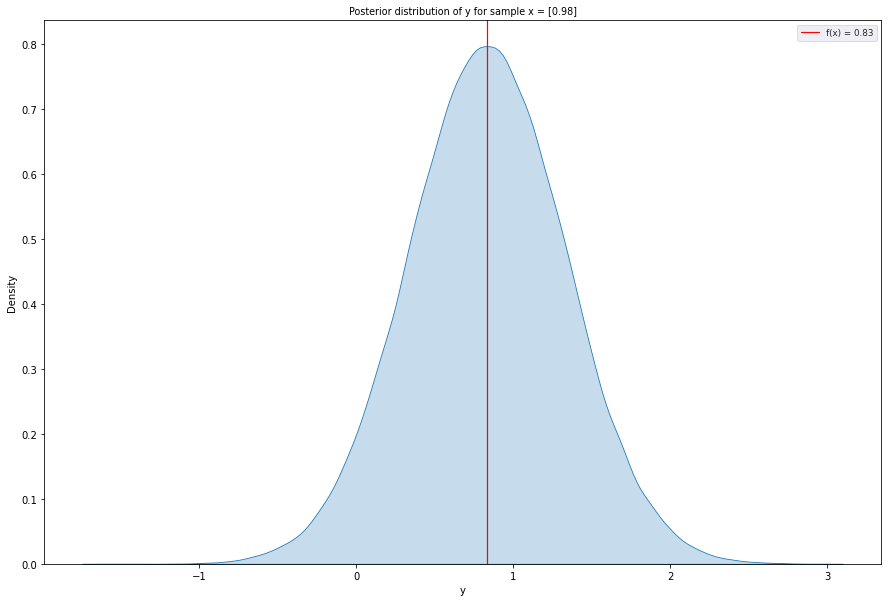

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test = torch.vstack((x_test_in_domain, x_test_out_domain))
y_test = torch.vstack((y_test_in_domain, y_test_out_domain))
print(x_test.shape, y_test.shape)

torch.Size([2000, 1]) torch.Size([2000, 1])


In [6]:
x_train.shape, y_train.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [7]:
x_test[0], y_test[0]

(tensor([-3.9116]), tensor([1.8410]))

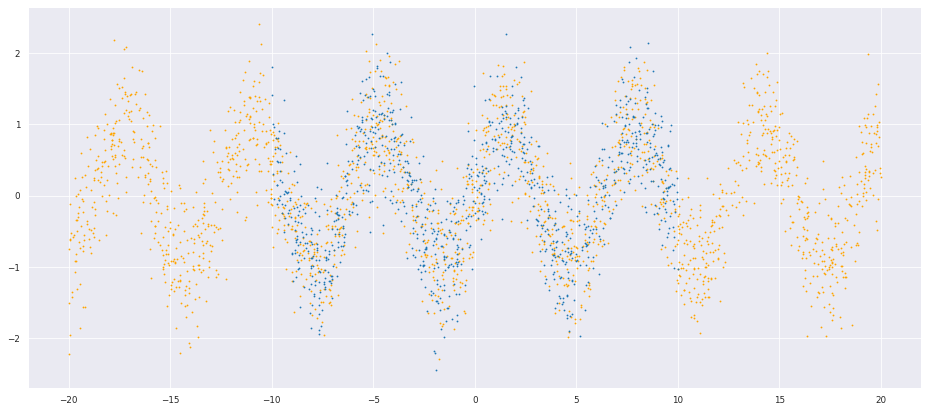

In [8]:
test_sort = torch.argsort(x_test.squeeze())
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1)


In [9]:
pyro.clear_param_store()

if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    train.train(config, dataset_config, f"{BASE_DIR}", reruns=3)

torch.Size([512, 1]) torch.Size([512, 1])
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Using device: cpu
===== Training profile tyxe-test - 1 =====


Sample: 100%|██████████| 15/15 [00:01,  8.10it/s, step size=5.73e-04, acc. prob=0.724]


(tensor(1.5957), tensor(0.1955))
Training finished in 0:00:01.868293 seconds
Saved MCMC model to ./tests/sanity_check_mcmc/models/tyxe-test/checkpoint_1.pt
File Size is 0.0810556411743164 MB
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Using device: cpu
===== Training profile tyxe-test - 2 =====


Sample: 100%|██████████| 15/15 [00:00, 15.50it/s, step size=2.29e-03, acc. prob=0.415]


(tensor(6.5390), tensor(0.4755))
Training finished in 0:00:00.981507 seconds
Saved MCMC model to ./tests/sanity_check_mcmc/models/tyxe-test/checkpoint_2.pt
File Size is 0.0810556411743164 MB
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Using device: cpu
===== Training profile tyxe-test - 3 =====


Sample: 100%|██████████| 15/15 [00:05,  2.55it/s, step size=7.84e-04, acc. prob=0.681]


(tensor(3.8563), tensor(2.3700))
Training finished in 0:00:05.903011 seconds
Saved MCMC model to ./tests/sanity_check_mcmc/models/tyxe-test/checkpoint_3.pt
File Size is 0.0810556411743164 MB


In [10]:
bnn = train.make_inference_model(config, dataset_config, device=config["DEVICE"])
bnn = train.load_bnn(bnn, config["INFERENCE_TYPE"], load_path=f"{BASE_DIR}/models/{NAME}/checkpoint_2.pt", device=config["DEVICE"])

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Loaded MCMC model from ./tests/sanity_check_mcmc/models/tyxe-test/checkpoint_2.pt


In [11]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

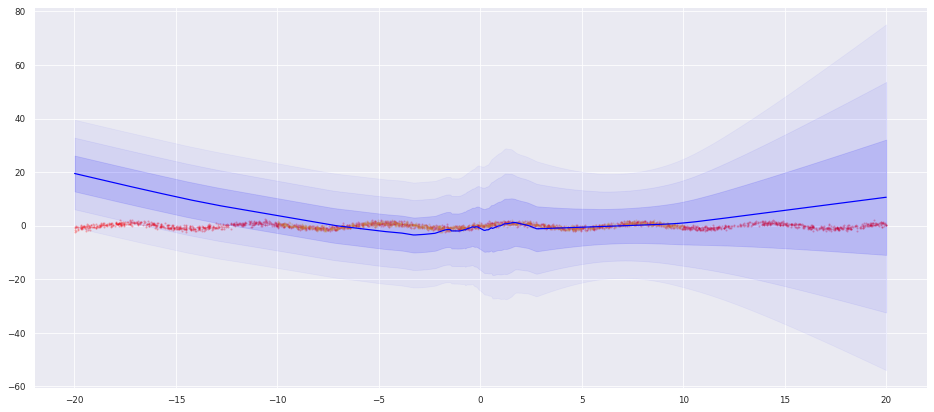

In [12]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

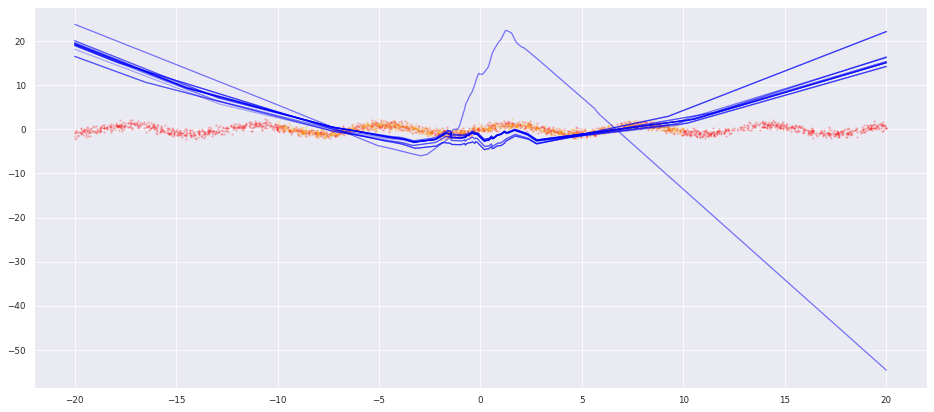

In [13]:
sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [15]:
if not os.path.exists(f"{BASE_DIR}/results"):
            os.mkdir(f"{BASE_DIR}/results")           
eval.eval(config, dataset_config, f"{BASE_DIR}", bnn=None, reruns=3)

data samples:  (10000, 1000)
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Loaded MCMC model from ./tests/sanity_check_mcmc/models/tyxe-test/checkpoint_1.pt
using device: cpu
====== evaluating profile tyxe-test - 1 ======
pred samples:  (10000, 1000)
Evaluating train...
Evaluating test...
Evaluating in_domain...
Evaluating out_domain...
Eval done in 0:00:22.007707
using device: cpu
====== evaluating profile tyxe-test - 2 ======
pred samples:  (10000, 1000)
Evaluating train...
Evaluating test...
Evaluating in_domain...
Evaluating out_domain...
Eval done in 0:00:21.207393
using device: cpu
====== evaluating profile tyxe-test - 3 ======
pred samples:  (10000, 1000)
Evaluating train...
Evaluating test...
Evaluating in_domain...
Evaluating out_domain...
Eval done in 0:00:22.101122


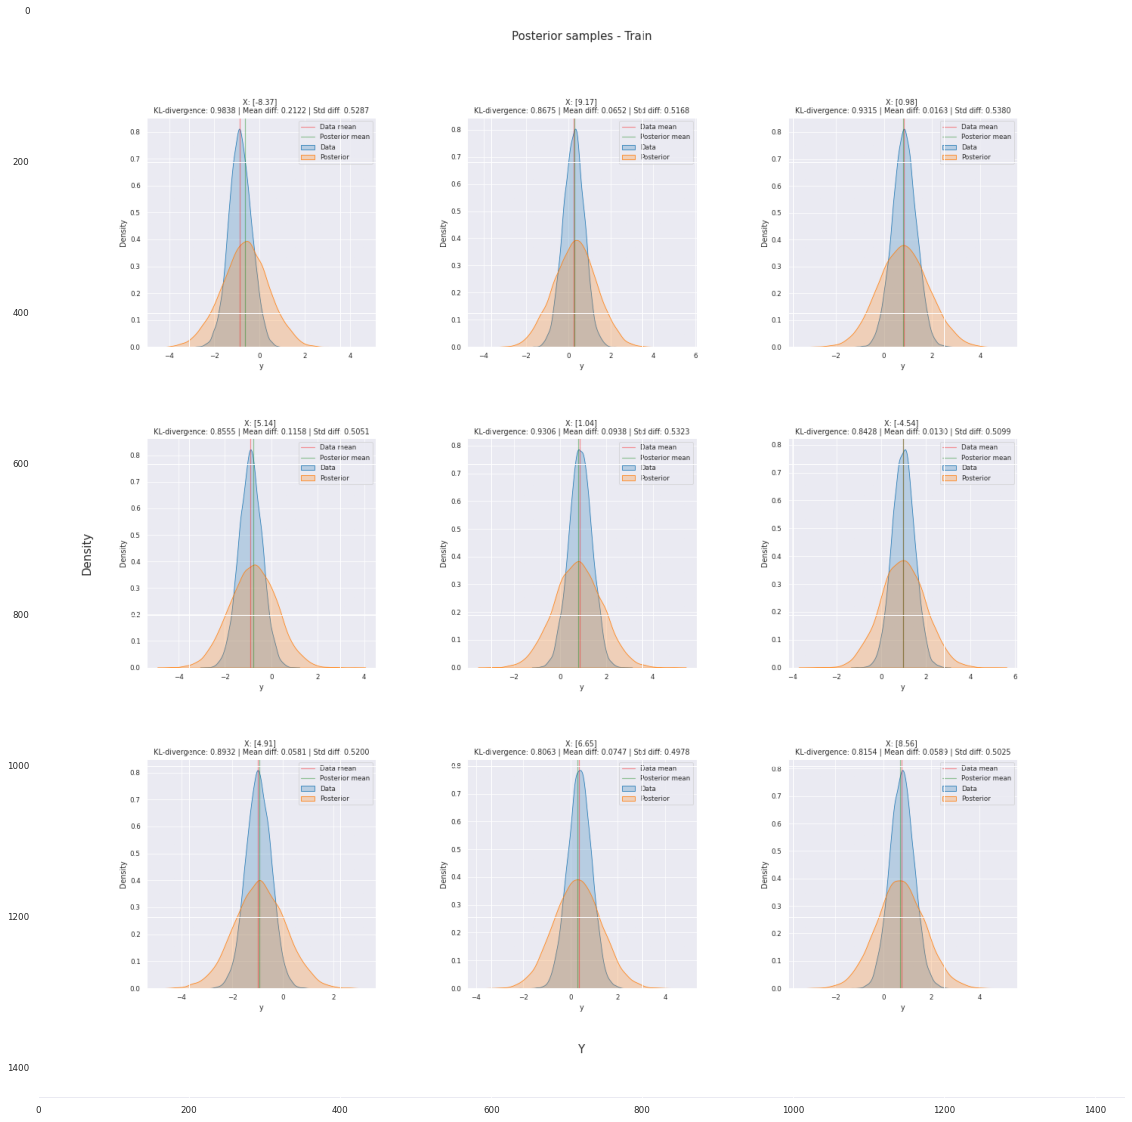

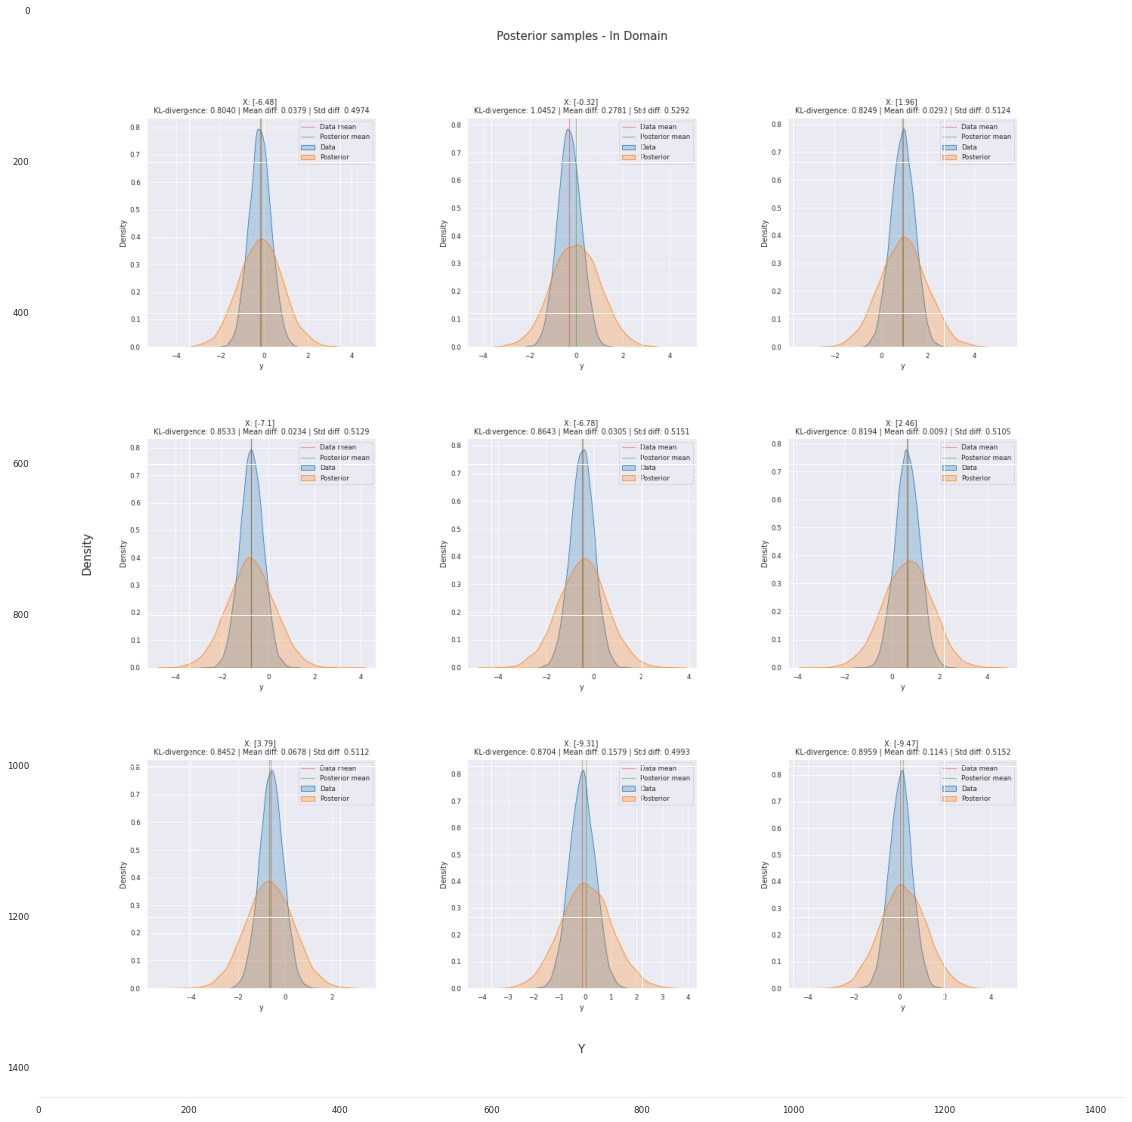

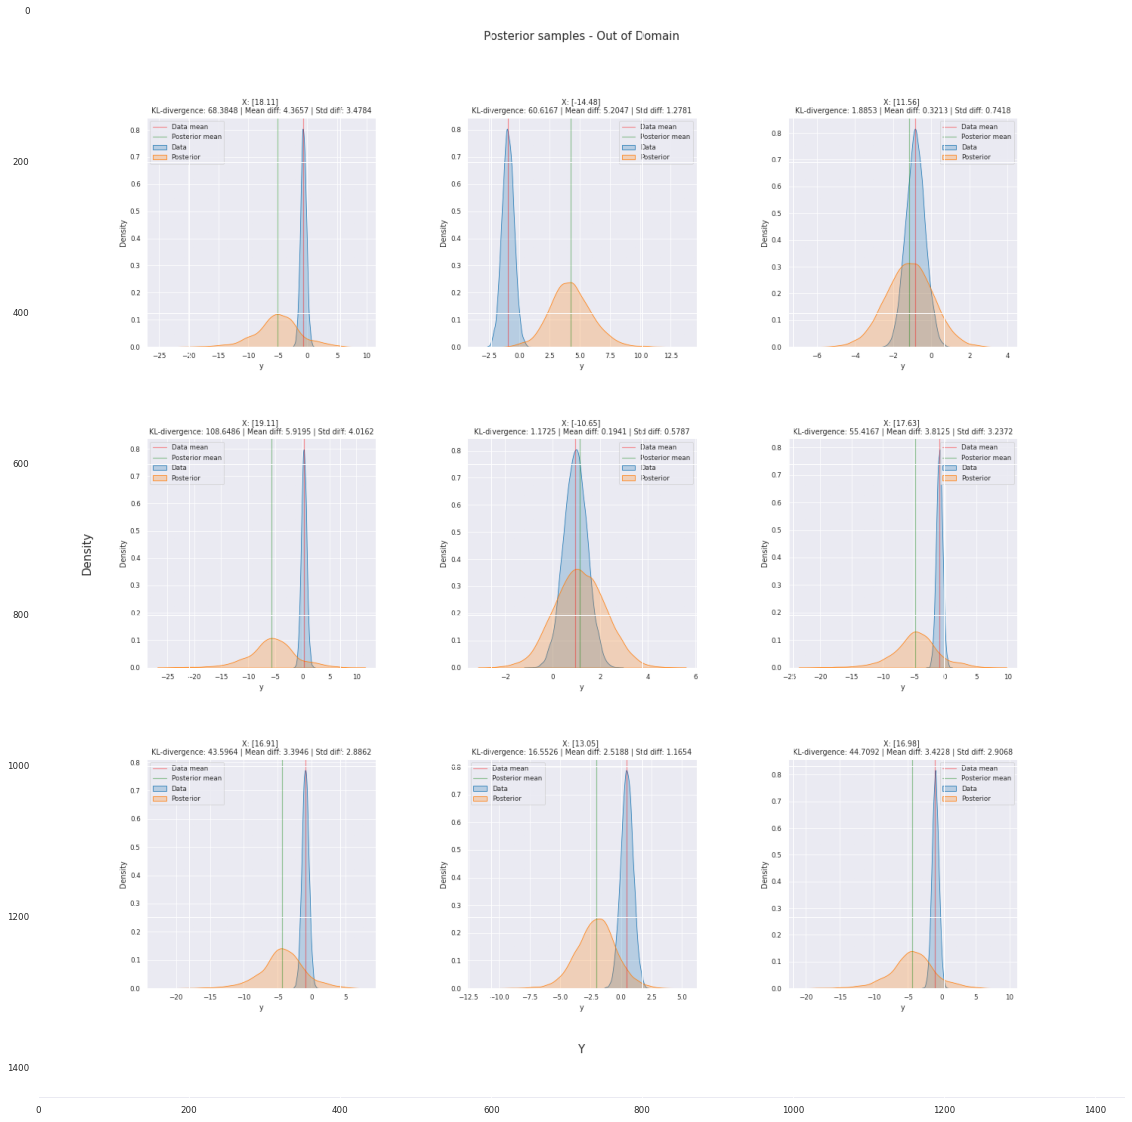

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/train_sanity_1.png"))

plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/test_in_domain_sanity_1.png"))

plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread(f"{BASE_DIR}/results/{NAME}/test_out_domain_sanity_1.png"))

In [17]:
file_stats = os.stat(f"{BASE_DIR}/models/{NAME}/checkpoint.pkl")

print(file_stats)
print(f'File Size in Bytes is {file_stats.st_size}')
print(f'File Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

FileNotFoundError: [Errno 2] No such file or directory: './tests/sanity_check_mcmc/models/tyxe-test/checkpoint.pkl'